<a href="https://colab.research.google.com/github/Meta-user-byte/Percevel/blob/main/Main_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install perceval-quandela==0.11.2 torch torchvision matplotlib numpy pandas

**Importing the libraries**

In [ ]:
import perceval as pcvl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from model import MnistModel
from training import fit

from utils import MNIST_partial, plot_training_metrics
from boson_sampler import BosonSampler
import perceval.providers.scaleway as scw

import numpy as np
import matplotlib.pyplot as plt

 **Define the Classical Convolutional Layers**

In [ ]:
class ClassicalCNN(nn.Module):
    def __init__(self, embedding_size=0):
        super(ClassicalCNN, self).__init__()
        self.embedding_size = embedding_size

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()

        fc_input_size = 64 * 7 * 7
        if embedding_size:
            fc_input_size += embedding_size  # Adjust for quantum embedding

        self.fc1 = nn.Linear(fc_input_size, 128)
        self.fc2 = nn.Linear(128, 10)  # MNIST has 10 classes

    def forward(self, x, emb=None):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flatten(x)
        if emb is not None:
            x = torch.cat((x, emb), dim=1)  # Concatenate classical and quantum embeddings
        x = F.relu(self.fc1(x))
        return self.fc2(x)

**Create the Quantum Embedding with Perceval (Boson Sampling)**

In [ ]:
def build_boson_sampler(modes=3):
    circuit = pcvl.Circuit(modes)
    for i in range(modes - 1):
        circuit.add((i, i + 1), pcvl.BS())
    return circuit

def encode_classical_data(circuit, classical_data):
    circuit.clear()
    for i, pixel in enumerate(classical_data):
        phase_shift = 2 * np.pi * pixel
        circuit.add(i % circuit.m, pcvl.PS(phase_shift))

**Simulate Boson Sampler:**

In [ ]:
def simulate_boson_sampler(circuit):
    backend = pcvl.BackendFactory().get_backend('SLOS')
    backend.set_circuit(circuit)
    backend.set_input_state(pcvl.BasicState([1, 0, 0]))  # Inject 1 photon
    return backend.prob_distribution()

**Wrap Quantum Embedding as a Keras-Compatible Layer (PyTorch Version)**

In [ ]:
class QuantumEmbeddingLayer(nn.Module):
    def __init__(self, modes=3):
        super(QuantumEmbeddingLayer, self).__init__()
        self.modes = modes
        self.circuit = build_boson_sampler(modes)
        self.backend = pcvl.BackendFactory().get_backend('SLOS')

    def forward(self, x):
        batch_size = x.shape[0]
        embeddings = []
        for i in range(batch_size):
            emb = simulate_boson_sampler(self.circuit).values()
            embeddings.append(torch.tensor(list(emb)))
        return torch.stack(embeddings)


**Combine Classical and Quantum Components into the Hybrid Model**

In [ ]:
class HybridModel(nn.Module):
    def __init__(self, embedding_size=0, modes=3):
        super(HybridModel, self).__init__()
        self.cnn = ClassicalCNN(embedding_size)
        self.quantum_layer = QuantumEmbeddingLayer(modes=modes)

    def forward(self, x):
        emb = self.quantum_layer(x)
        return self.cnn(x, emb)

**Device init**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'mps' if torch.backends.mps.is_available() and torch.backends.mps.is_built() else device

device

'mps'

**Hyperparameters init**

In [ ]:
epochs = 20
lr = 0.005

path_folder_classical = "checkpoints mps classical"
path_folder_quantum = "checkpoints mps quantum"

batch_size = 32

**Data Loading**

In [ ]:
train_dataset = MNIST_partial(data="/Users/soardr/Perceval 2/Percevel-main/data", split = 'train')
val_dataset = MNIST_partial(data="/Users/soardr/Perceval 2/Percevel-main/data", split='val')

# definition of the dataloader, to process the data in the model
# here, we need a batch size of 1 to use the boson sampler
train_loader = DataLoader(train_dataset, batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size, shuffle = False)

#### START SCALEWAY SESSION ####
session = None
# to run a remote session on Scaleway, uncomment the following and fill project_id and token
# session = scw.Session(
#                    platform="sim:sampling:p100",  # or sim:sampling:h100
#                    project_id=""  # Your project id,
#                    token=""  # Your personal API key
#                    )

# start session
if session is not None:
    session.start()

#### BOSON SAMPLER DEFINITION ####
# here, we use 30 photons and 2 modes
bs = BosonSampler(30, 2, postselect = 2, session = session)
print(f"Boson sampler defined with number of parameters = {bs.nb_parameters}, and embedding size = {bs.embedding_size}")

Boson sampler defined with number of parameters = 855, and embedding size = 435


In [ ]:
bs.embedding_size

435

**Circuit Display**

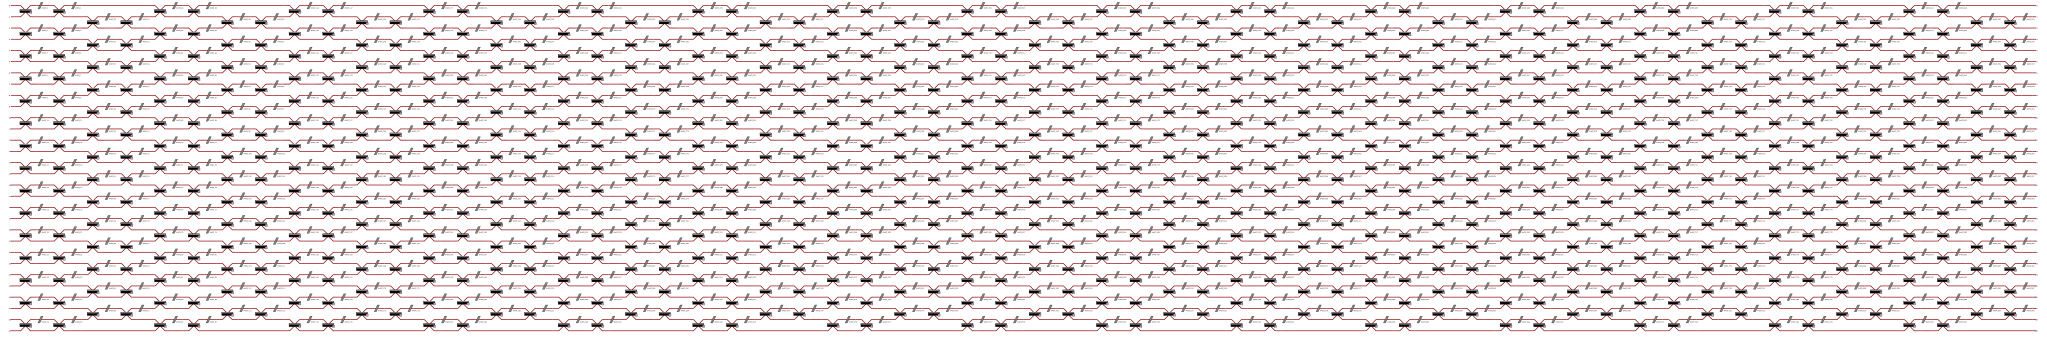

In [ ]:
pcvl.pdisplay(bs.create_circuit())

##Classical Model

In [ ]:
#### MODEL ####
# define the model and send it to the appropriate device
# set embedding_size = bs.embedding_size if you want to use the boson sampler in input of the model
model = MnistModel(device = device)
# model = MnistModel(device = device, embedding_size = bs.embedding_size)
model = model.to(device)
# train the model with the chosen parameters
experiment_classical = fit(epochs=epochs, lr=lr, model_temp=model, train_loader=train_loader, val_loader=val_loader, bs=bs, device=device, file_path=path_folder_classical)

**Output after the fit function:**

In [ ]:
experiment_classical = [{'val_loss': 1.6126017570495605, 'val_acc': 0.7275219559669495},
 {'val_loss': 1.2614126205444336, 'val_acc': 0.7987938523292542},
 {'val_loss': 1.0625039339065552, 'val_acc': 0.8152412176132202},
 {'val_loss': 0.9384596943855286, 'val_acc': 0.828399121761322},
 {'val_loss': 0.8534402251243591, 'val_acc': 0.8333333134651184},
 {'val_loss': 0.7885497212409973, 'val_acc': 0.84375},
 {'val_loss': 0.7412248253822327, 'val_acc': 0.8503289222717285},
 {'val_loss': 0.703043520450592, 'val_acc': 0.8503289222717285},
 {'val_loss': 0.6709198355674744, 'val_acc': 0.8503289222717285},
 {'val_loss': 0.6446147561073303, 'val_acc': 0.8536184430122375},
 {'val_loss': 0.6222571134567261, 'val_acc': 0.8519737124443054},
 {'val_loss': 0.6027383208274841, 'val_acc': 0.8519737124443054},
 {'val_loss': 0.5855684876441956, 'val_acc': 0.8569079041481018},
 {'val_loss': 0.5712098479270935, 'val_acc': 0.8552631735801697},
 {'val_loss': 0.5584878325462341, 'val_acc': 0.8552631735801697},
 {'val_loss': 0.5471354126930237, 'val_acc': 0.8552631735801697},
 {'val_loss': 0.5358783602714539, 'val_acc': 0.8601973652839661},
 {'val_loss': 0.5262813568115234, 'val_acc': 0.8585526347160339},
 {'val_loss': 0.5168095827102661, 'val_acc': 0.8618420958518982},
 {'val_loss': 0.5093955993652344, 'val_acc': 0.8667762875556946}]

Plotting the results

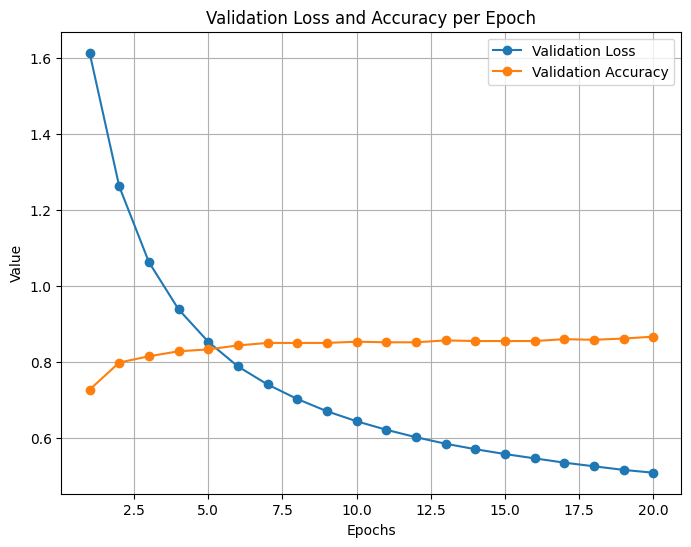

In [ ]:
# Extract values
val_loss = [entry['val_loss'] for entry in experiment_classical]
val_acc = [entry['val_acc'] for entry in experiment_classical]
epochs = range(1, len(experiment_classical) + 1)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')

# Labels and legend
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Validation Loss and Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

## Quantum-Hybrid Model

In [ ]:
model_quantum = MnistModel(device=device, embedding_size=bs.embedding_size)

In [ ]:
# Train the model
experiment_quantum = fit(epochs=epochs, lr=lr, model_temp=model_quantum, train_loader=train_loader, val_loader=val_loader, bs=bs, device=device, file_path=path_folder_quantum)

In [ ]:
experiment_quantum = [{'val_loss': 1.634355068206787, 'val_acc': 0.7390351295471191},
 {'val_loss': 1.269916296005249, 'val_acc': 0.8086622357368469},
 {'val_loss': 1.0686378479003906, 'val_acc': 0.8185306787490845},
 {'val_loss': 0.9407892823219299, 'val_acc': 0.8234648704528809},
 {'val_loss': 0.8515903949737549, 'val_acc': 0.8333333134651184},
 {'val_loss': 0.7887521386146545, 'val_acc': 0.8355262875556946},
 {'val_loss': 0.741230845451355, 'val_acc': 0.8388158082962036},
 {'val_loss': 0.6998286843299866, 'val_acc': 0.8421052694320679},
 {'val_loss': 0.6696580648422241, 'val_acc': 0.8486841917037964},
 {'val_loss': 0.6434544324874878, 'val_acc': 0.8486841917037964},
 {'val_loss': 0.6202046871185303, 'val_acc': 0.8519737124443054},
 {'val_loss': 0.6008215546607971, 'val_acc': 0.8519737124443054},
 {'val_loss': 0.5838422179222107, 'val_acc': 0.8519737124443054},
 {'val_loss': 0.5696349740028381, 'val_acc': 0.8569079041481018},
 {'val_loss': 0.5556744933128357, 'val_acc': 0.8536184430122375},
 {'val_loss': 0.5433870553970337, 'val_acc': 0.8585526347160339},
 {'val_loss': 0.5336459875106812, 'val_acc': 0.8585526347160339},
 {'val_loss': 0.5229863524436951, 'val_acc': 0.8601973652839661},
 {'val_loss': 0.5153440833091736, 'val_acc': 0.865679919719696},
 {'val_loss': 0.5063205361366272, 'val_acc': 0.862390398979187}]

Plot results for quantum-hybrid model

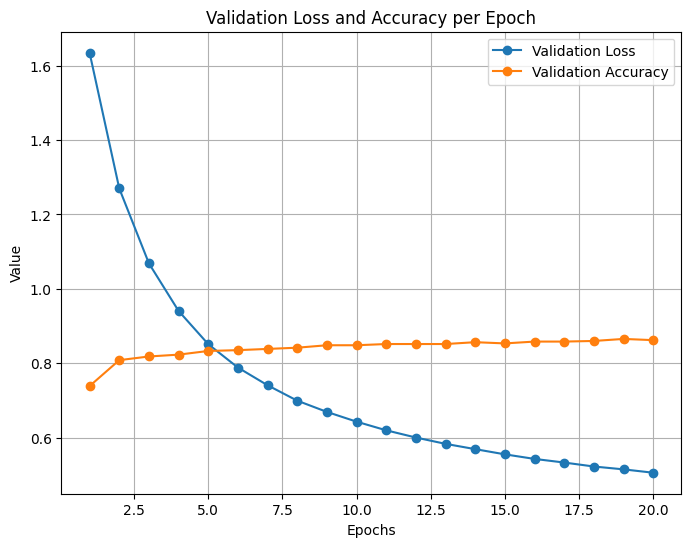

In [ ]:
# Extract values
val_loss = [entry['val_loss'] for entry in experiment_quantum]
val_acc = [entry['val_acc'] for entry in experiment_quantum]
epochs = range(1, len(experiment_quantum) + 1)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')

# Labels and legend
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Validation Loss and Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

## Loading the checkpoint for both the models

In [ ]:
# Loading the checkpoint for classical model:

model_classical_checkpoint = MnistModel(device=device)
classical_checkpoint = torch.load("/Users/soardr/Perceval 2/Percevel-main/checkpoints mps classical batch32/epoch_10.pth")
classical_optimizer = torch.optim.SGD(model_classical_checkpoint.parameters(), lr=lr)

model_classical_checkpoint.load_state_dict(classical_checkpoint['model_statedict'])
classical_optimizer.load_state_dict(classical_checkpoint['optimizer_statedict'])

/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_26073/2625515388.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classical_checkpoint = torch.load("/Users/soa

In [ ]:
# Loading the checkpoint for quantum-hybrid model:

model_quantum_checkpoint = MnistModel(device=device, embedding_size=bs.embedding_size)
quantum_checkpoint = torch.load("/Users/soardr/Perceval 2/Percevel-main/checkpoints mps quantum batch32/epoch_10.pth")
quantum_optimizer = torch.optim.SGD(model_quantum_checkpoint.parameters(), lr=lr)

model_quantum_checkpoint.load_state_dict(quantum_checkpoint['model_statedict'])
quantum_optimizer.load_state_dict(quantum_checkpoint['optimizer_statedict'])

/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_26073/1326906518.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  quantum_checkpoint = torch.load("/Users/soard

In [ ]:
model_classical_checkpoint.to(device)
model_quantum_checkpoint.to(device)

MnistModel(
  (linear): Linear(in_features=1219, out_features=10, bias=True)
)

## Comparing the models on testing data using evaluate function

In [ ]:
from model import evaluate

In [ ]:
# Evaluation result for classical model
classical_result = evaluate(model_classical_checkpoint, val_loader, bs)
print(f"Validation Accuracy for classical model checkpoint: {classical_result['val_acc']:.2f}")

Validation Accuracy for classical model checkpoint: 0.85


In [ ]:
# Evaluation result for quantum model
quantum_result = evaluate(model_quantum_checkpoint, val_loader, bs)
print(f"Validation Accuracy for quantum model checkpoint: {classical_result['val_acc']:.2f}")

  0%|          | 0/19 [00:00<?, ?it/s]

inside boson sampler; images and labs data: torch.Size([32, 1, 28, 28]) torch.Size([32])
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as co

  5%|▌         | 1/19 [00:05<01:42,  5.72s/it]

inside boson sampler; images and labs data: torch.Size([32, 1, 28, 28]) torch.Size([32])
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as co

 11%|█         | 2/19 [00:11<01:34,  5.56s/it]

inside boson sampler; images and labs data: torch.Size([32, 1, 28, 28]) torch.Size([32])
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as co

 16%|█▌        | 3/19 [00:16<01:28,  5.53s/it]

[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
info about embs: <class 'torch.Tensor'> torch.Size([32, 435])
inside boson sampler; images and labs data: torch.Size([32, 1, 28, 28]) torch.Size([32])
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated funct

 21%|██        | 4/19 [00:21<01:21,  5.42s/it]

inside boson sampler; images and labs data: torch.Size([32, 1, 28, 28]) torch.Size([32])
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as co

 26%|██▋       | 5/19 [00:27<01:16,  5.44s/it]

info about embs: <class 'torch.Tensor'> torch.Size([32, 435])
inside boson sampler; images and labs data: torch.Size([32, 1, 28, 28]) torch.Size([32])
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated funct

 32%|███▏      | 6/19 [00:32<01:10,  5.46s/it]

[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
info about embs: <class 'torch.Tensor'> torch.Size([32, 435])
inside boson sampler; images and labs data: torch.Size([32, 1, 28, 28]) torch.Size([32])
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated funct

 37%|███▋      | 7/19 [00:38<01:05,  5.49s/it]

[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
info about embs: <class 'torch.Tensor'> torch.Size([32, 435])
inside boson sampler; images and labs data: torch.Size([32, 1, 28, 28]) torch.Size([32])
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated funct

 42%|████▏     | 8/19 [00:45<01:06,  6.06s/it]

[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
info about embs: <class 'torch.Tensor'> torch.Size([32, 435])
inside boson sampler; images and labs data: torch.Size([32, 1, 28, 28]) torch.Size([32])
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated funct

 47%|████▋     | 9/19 [00:55<01:11,  7.16s/it]

[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
info about embs: <class 'torch.Tensor'> torch.Size([32, 435])
inside boson sampler; images and labs data: torch.Size([32, 1, 28, 28]) torch.Size([32])
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated funct

 53%|█████▎    | 10/19 [01:04<01:11,  7.92s/it]

[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
info about embs: <class 'torch.Tensor'> torch.Size([32, 435])
inside boson sampler; images and labs data: torch.Size([32, 1, 28, 28]) torch.Size([32])
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated funct

 58%|█████▊    | 11/19 [01:13<01:06,  8.26s/it]

[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
info about embs: <class 'torch.Tensor'> torch.Size([32, 435])
inside boson sampler; images and labs data: torch.Size([32, 1, 28, 28]) torch.Size([32])
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated funct

 63%|██████▎   | 12/19 [01:23<00:59,  8.51s/it]

[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
info about embs: <class 'torch.Tensor'> torch.Size([32, 435])
inside boson sampler; images and labs data: torch.Size([32, 1, 28, 28]) torch.Size([32])
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated funct

 68%|██████▊   | 13/19 [01:31<00:51,  8.63s/it]

[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
info about embs: <class 'torch.Tensor'> torch.Size([32, 435])
inside boson sampler; images and labs data: torch.Size([32, 1, 28, 28]) torch.Size([32])
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated funct

 74%|███████▎  | 14/19 [01:40<00:43,  8.76s/it]

[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
info about embs: <class 'torch.Tensor'> torch.Size([32, 435])
inside boson sampler; images and labs data: torch.Size([32, 1, 28, 28]) torch.Size([32])
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated funct

 79%|███████▉  | 15/19 [01:49<00:35,  8.80s/it]

[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
info about embs: <class 'torch.Tensor'> torch.Size([32, 435])
inside boson sampler; images and labs data: torch.Size([32, 1, 28, 28]) torch.Size([32])
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated funct

 84%|████████▍ | 16/19 [01:59<00:26,  8.92s/it]

[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
info about embs: <class 'torch.Tensor'> torch.Size([32, 435])
inside boson sampler; images and labs data: torch.Size([32, 1, 28, 28]) torch.Size([32])
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated funct

 89%|████████▉ | 17/19 [02:08<00:17,  8.96s/it]

[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
info about embs: <class 'torch.Tensor'> torch.Size([32, 435])
inside boson sampler; images and labs data: torch.Size([32, 1, 28, 28]) torch.Size([32])
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated funct

 95%|█████████▍| 18/19 [02:17<00:08,  8.97s/it]

[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
info about embs: <class 'torch.Tensor'> torch.Size([32, 435])
inside boson sampler; images and labs data: torch.Size([24, 1, 28, 28]) torch.Size([24])
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
[warning] DeprecationWarning: Call to deprecated funct

100%|██████████| 19/19 [02:23<00:00,  7.57s/it]

[warning] DeprecationWarning: Call to deprecated function (or staticmethod) thresholded_output. (Add detectors as components) -- Deprecated since version 0.12
info about embs: <class 'torch.Tensor'> torch.Size([24, 435])
Validation Accuracy for quantum model checkpoint: 0.85
